In [27]:
import numpy as np 
import tensorflow as tf
import matplotlib.pyplot as plt 

import collections
import hashlib
import numbers
import matplotlib.cm as cm
from sys import getsizeof

from tensorflow.python.eager import context
from tensorflow.python.framework import constant_op
from tensorflow.python.framework import dtypes
from tensorflow.python.framework import ops
from tensorflow.python.framework import tensor_shape
from tensorflow.python.framework import tensor_util
from tensorflow.python.layers import base as base_layer
from tensorflow.python.ops import array_ops
from tensorflow.python.ops import clip_ops
from tensorflow.python.ops import init_ops
from tensorflow.python.ops import math_ops
from tensorflow.python.ops import nn_ops
from tensorflow.python.ops import partitioned_variables
from tensorflow.python.ops import random_ops
from tensorflow.python.ops import tensor_array_ops
from tensorflow.python.ops import variable_scope as vs
from tensorflow.python.ops import variables as tf_variables
from tensorflow.python.platform import tf_logging as logging
from tensorflow.python.util import nest
from tensorflow.contrib.rnn.python.ops.core_rnn_cell import _Linear
from tensorflow.contrib import slim

In [28]:
# uplading mnist data 

old_v = tf.logging.get_verbosity()
tf.logging.set_verbosity(tf.logging.ERROR)

from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)
train_data = mnist.train.images  # Returns np.array
train_labels = np.asarray(mnist.train.labels, dtype=np.int32)
eval_data = mnist.test.images  # Returns np.array
eval_labels = np.asarray(mnist.test.labels, dtype=np.int32)

tf.logging.set_verbosity(old_v)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [29]:
# Training Parameters
learning_rate = 1e-5
training_steps = 5000
batch_size = 128
display_step = 200
test_len=128
grad_clip=200
# Network Parameters
num_input = 1 # MNIST data input (img shape: 28*28)
timesteps = 28*28 # timesteps
num_hidden = 200 # hidden layer num of features
num_classes = 10 # MNIST total classes (0-9 digits)

# tf Graph input


create a tuple object for the cell, 

In [44]:
_KernelRNNStateTuple = collections.namedtuple("KernelRNNStateTuple", ("h","h_hat","Theta", "Gamma","input_trace","recurrent_trace","delta_sensitivity"))
_KernelRNNOutputTuple = collections.namedtuple("KernelRNNOutputTuple", ("h","h_hat","Theta","Gamma", "input_trace","recurrent_trace","delta_sensitivity"))

class KernelRNNStateTuple(_KernelRNNStateTuple):
  """Tuple used by kernel RNN Cells for `state_variables `.
  Stores 9 elements: `(h, h_hat, Theta, Gamma, input_trace,recurrent_trace, sensitivty_tensor, kernel_coeff`, in that order. 
  always is used for this type of cell
  """
  __slots__ = ()

  @property
  def dtype(self):
    (h, h_hat,Theta , Gamma, input_trace,recurrent_trace, delta_sensitivity ) = self
    if h.dtype != h_hat.dtype:
      raise TypeError("Inconsistent internal state: %s vs %s" %
                      (str(h.dtype), str(h_hat.dtype)))
    return h_hat.dtype


class KernelRNNOutputTuple(_KernelRNNOutputTuple):
  """Tuple used by kernel Cells for output state.
  Stores 7 elements: `(h,h_hat, Theta, Gamma, input_trace, recurrent_trace)`, 
  Only used when `output_is_tuple=True`.
  """
  __slots__ = ()

  @property
  def dtype(self):
    (h, h_hat,Theta , Gamma, input_trace,recurrent_trace, delta_sensitivity) = self
    if h.dtype != h_hat.dtype:
      raise TypeError("Inconsistent internal state: %s vs %s" %
                      (str(h.dtype), str(h_hat.dtype)))
    return h_hat.dtype


In [62]:
## expand dimensions for incoming recurrent and input activations for multiplication with current acivation 
def _tensor_expand_dim(x,y,output_size):
    """input - x : a 2D tensor with batch x n 
    y is a 2D with size batch x m
    outputs is 3D tensor with size batch x n x n and batch x n x m 
    """ 
    shape_x=x.get_shape()
    shape_y=y.get_shape()
    #y=tf.cast(y,tf.float32)
    # define a matrix for removing the diagonal in recurrent spikes 
    diag_zero= lambda:tf.subtract(tf.constant(1.0,shape=[shape_x[1],shape_x[1]]),
                                                    tf.eye(output_size))
    x_diag_fixer = tf.Variable(initial_value=diag_zero, dtype=tf.float32,name='diag_fixer', trainable=False)
    # expand x  
    x_temp=tf.reshape(tf.tile(x,[1,output_size]),[-1,output_size,shape_x[1]])
    # remove diagonal 
    x_expand=tf.multiply(x_temp,x_diag_fixer)
    # expand y  
    y_expand=tf.reshape(tf.tile(y,[1,output_size]),[-1,output_size,shape_y[1]])
    return x_expand, y_expand


def _gaussian_noise_perturbation(input_layer, std):
    noise = tf.random_normal(shape=tf.shape(input_layer), mean=0.0, stddev=std, dtype=tf.float32) 
    return tf.multiply(input_layer,0) + noise


def _kernel_coeff_initializer(shape,dtype=None,partition_info=None,verify_shape=None, max_val=1):
    if dtype is None: 
        dtype=tf.float32
        
    return tf.random_uniform(shape,0,max_val,dtype=dtype)


create a Kernel RNN cell 

In [63]:
_KERNEL_COEF_NAME= "temporal_kernel_coeff"
_SENSITIVITY_TENSOR_NAME= "sensitivity_tensor"

class KernelRNNCell(tf.contrib.rnn.RNNCell):
    """Kernel recurrent neural network Cell
      Args:
        num_units: int, The number of units in the cell.
        activation: Nonlinearity to use.  Default: `Relu`.
        eligibility_kernel: kernel funtion to use for elibility 
        reuse: (optional) Python boolean describing whether to reuse variables
         in an existing scope.  If not `True`, and the existing scope already has
         the given variables, an error is raised.
        kernel_initializer: (optional) The initializer to use for the weight and
        projection matrices.
        bias_initializer: (optional) The initializer to use for the bias.
    """
    def __init__(self,
                 num_units,
                 num_inputs,
                 time_steps=1,
                 noise_std=1.0,
                 activation=None,
                 reuse=None,
                 eligibility_kernel=None,
                 state_is_tuple=True,
                 output_is_tuple=False,
                 batch_KeRNL=True,
                 sensitivity_initializer=None,
                 kernel_coeff_initializer=None,
                 kernel_initializer=None,
                 bias_initializer=None):
        
        super(KernelRNNCell,self).__init__(_reuse=reuse)
        self._num_units = num_units
        self._num_inputs= num_inputs
        self._time_steps= time_steps
        self._activation = activation or math_ops.tanh
        self._eligibility_kernel = eligibility_kernel or math_ops.exp
        self._noise_std=noise_std
        self._linear = None
        self._state_is_tuple=state_is_tuple
        self._output_is_tuple= output_is_tuple
        self._batch_KeRNL=batch_KeRNL
        self._tensor_expand_dim=_tensor_expand_dim
        self._gaussian_noise_perturbation=_gaussian_noise_perturbation
        self._sensitivity_initializer=sensitivity_initializer
        self._kernel_coeff_initializer=kernel_coeff_initializer
        self._kernel_initializer=kernel_initializer
        self._bias_initializer=bias_initializer
    
    @property
    # h,h_hat,Theta, Gamma,input_trace,recurrent_trace,sensitivty_tensor,kernel_coeff
    def state_size(self):
        return (KernelRNNStateTuple(self._num_units, 
                                    self._num_units, 
                                    self._num_units, 
                                    self._num_units, 
                                    np.array([self._num_units,self._num_inputs]), 
                                    np.array([self._num_units,self._num_units]),
                                    self._num_units)
                if self._state_is_tuple else self._num_units)
    @property
    def output_size(self):
        return (KernelRNNOutputTuple(self._num_units, 
                                    self._num_units, 
                                    self._num_units, 
                                    self._num_units, 
                                    np.array([self._num_units,self._num_inputs]), 
                                    np.array([self._num_units,self._num_units]),
                                    self._num_units)
                if self._output_is_tuple else self._num_units)

    # call function routine 
    def call(self, inputs, state):
        """Kernel RNN cell (KernelRNN).
        Args:
          inputs: `2-D` tensor with shape `[batch_size x input_size]`.
          state: An `KernelRNNStateTuple` of state tensors, shaped as following 
            h:                   [batch_size x self.state_size]`
            h_hat:               [batch_size x self.state_size]`
            Theta:               [batch_size x self.state_size]`
            Gamma:               [batch_size x self.state_size]`
            input_trace          [batch_size x self.state_size x self.input_size]`
            recurrent_trace      [batch_size x self.state_size x self.state_size]`
            delta_sensitivity    [batch_size x self.state_size]`
        Returns:
          A pair containing the new output, and the new state as SNNStateTuple
          output has the following shape 
            h:                   [batch_size x self.state_size]`
            h_hat:               [batch_size x self.state_size]`
            Theta:               [batch_size x self.state_size]`
            Gamma:               [batch_size x self.state_size]`
            input_trace          [batch_size x self.state_size x self.input_size]`
            recurrent_trace      [batch_size x self.state_size x self.state_size]`
            delta_sensitivity    [batch_size x self.state_size]`
        """
        # initialize kernel_coeff
        scope=vs.get_variable_scope()
        if self._kernel_coeff_initializer is None:
            kernel_initializer=init_ops.constant_initializer(1/self._time_steps,dtype=tf.float32)
        else: 
            kernel_initializer=self._kernel_coeff_initializer
        with vs.variable_scope(scope,initializer=kernel_initializer) as kernel_scope:
            kernel_coeff=tf.get_variable(_KERNEL_COEF_NAME,shape=[self._num_units],dtype=tf.float32,trainable=True)
        
        # initialize Sensitivity_tensor
        scope=vs.get_variable_scope()
        if self._sensitivity_initializer is None:
            sensitivity_initializer=init_ops.truncated_normal_initializer
        else: 
            sensitivity_initializer=self._sensitivity_initializer
        with vs.variable_scope(scope,initializer=sensitivity_initializer) as sensitivity_scope:
            sensitivity_tensor=tf.get_variable(_SENSITIVITY_TENSOR_NAME,shape=[self._num_units,self._num_units],dtype=tf.float32,trainable=True)
        
            
        
        if self._state_is_tuple:
            h, h_hat, Theta, Gamma, input_trace, recurrent_trace, delta_sensitivity= state
        else:
            logging.error("State has to be tuple for this type of cell")
        
        if self._linear is None: 
            self._linear = _Linear([inputs, h], self._num_units, True)
        psi_new=self._gaussian_noise_perturbation(h,self._noise_std)
        
        # propagate data forward 
        h_new=self._activation(self._linear([inputs,h]))
        
        # propagate noisy data forward 
        h_hat_update=tf.add(h_hat,psi_new)
        h_hat_new= self._activation(self._linear([inputs, h_hat_update]))
        # TODO : check if weights get reused 
        
        # integrate over perturbations
        Theta_new=tf.add(tf.multiply(self._eligibility_kernel(-kernel_coeff),
                              Theta),psi_new)
        
        # derivative of perturbation w.r.t to kernel_coeff
        Gamma_new=tf.subtract(tf.multiply(self._eligibility_kernel(-kernel_coeff),
                              Gamma),
                             tf.multiply(self._eligibility_kernel(-kernel_coeff),
                              Theta))
        
        # update elgibility traces for input and recurrent units 
        recurrent_expand,inputs_expand=self._tensor_expand_dim(h,inputs,self._num_units)
        g_new=self._linear([inputs,h])
        pre_activation=self._activation(g_new)
        activation_gradients=tf.gradients(pre_activation,g_new)[0] # convert list to a tensor 
        gradient_expansion=tf.expand_dims(activation_gradients,axis=-1)
        input_trace_update=tf.multiply(gradient_expansion,inputs_expand)
        recurrent_trace_update=tf.multiply(gradient_expansion,recurrent_expand)
        
        # calculate error in predicting effect of perturbation 
        #delta_sensitivity_new=tf.subtract(tf.matmul(Theta_new,tf.transpose(se)),
        #                                  tf.subtract(h_hat_new-h_new)
        #                                 )
        #logging.warn("%s: input_trace ", input_trace.get_shape())
        kernel_decay=tf.expand_dims(self._eligibility_kernel(-kernel_coeff),axis=-1)
        # update input trace 
        input_trace_decay=tf.multiply(kernel_decay,input_trace)
        input_trace_new=tf.add(input_trace_decay,input_trace_update)

        # update recurrent trace  
        recurrent_trace_decay=tf.multiply(kernel_decay,recurrent_trace)
        recurrent_trace_new=tf.add(recurrent_trace_decay,recurrent_trace_update)

        # TODO implement online updating for sensitivity and kernel coeff
        delta_sensitivity_new=delta_sensitivity
        
        if self._state_is_tuple: 
            new_state=KernelRNNStateTuple(h_new,h_hat_new,Theta_new,Gamma_new,input_trace_new,
                                          recurrent_trace_new,delta_sensitivity_new)
        if self._output_is_tuple:
            new_output=KernelRNNOutputTuple(h_new,h_hat_new,Theta_new,Gamma_new,input_trace_new,
                                          recurrent_trace_new,delta_sensitivity_new)
        else:
            new_output=h_new

        return new_output, new_state
        
    
    
    

test the network 

In [64]:
def kernel_RNN(x, weights, biases):

    # Prepare data shape to match `rnn` function requirements
    # Current data input shape: (batch_size, timesteps, n_input)
    # Required shape: 'timesteps' tensors list of shape (batch_size, n_input)

    # Unstack to get a list of 'timesteps' tensors of shape (batch_size, n_input)
    
    # using variable scope to initialize to identity 
    with tf.variable_scope('recurrent',initializer=tf.initializers.identity()) as scope: 
        # Define a lstm cell with tensorflow
        kernel_cell = KernelRNNCell(num_units=num_hidden,num_inputs=num_input,time_steps=timesteps)
        rnn_cell = tf.contrib.rnn.BasicRNNCell(num_hidden,name='irnn')
        # Get lstm cell output
        kernel_outputs, kernel_states = tf.nn.dynamic_rnn(kernel_cell, x, dtype=tf.float32)
        rnn_outputs, rnn_states = tf.nn.dynamic_rnn(rnn_cell, x, dtype=tf.float32)

    # Linear activation, using rnn inner loop last output
    return tf.matmul(kernel_outputs[:,-1,:], weights['out']) + biases['out'], kernel_outputs, tf.matmul(rnn_outputs[:,-1,:], weights['out']) + biases['out'], rnn_outputs

In [65]:
tf.reset_default_graph()
graph=tf.Graph()
with graph.as_default():
    # Define weights
    weights = {
        'out': tf.Variable(tf.random_normal([num_hidden, num_classes]),name='output_weight')
    }
    biases = {
        'out': tf.Variable(tf.random_normal([num_classes]),name='output_bias')
    }
    X = tf.placeholder("float", [None, timesteps, num_input])
    Y = tf.placeholder("float", [None, num_classes])
    kernel_logits, kernel_all_logits,rnn_logits, rnn_all_logits = kernel_RNN(X, weights, biases)
    prediction = tf.nn.softmax(kernel_logits)
    init = tf.global_variables_initializer()
    variable_names=[v.name for v in tf.all_variables()]
    

In [66]:
with tf.Session(graph=graph) as sess : 
    sess.run(init)
    values = sess.run(variable_names)
    for k, v in zip(variable_names,values):
        print(["variable: " , k])
        print(["value: " , v])
        print(["variable: " , np.unicode_.find(k,'output')]) 
        print(["shape: " , v.shape])
        #print(v) 


['variable: ', 'output_weight:0']
['value: ', array([[ 0.1104304 , -0.3829989 ,  0.39402223, ..., -0.77241457,
        -1.9010522 , -0.8359708 ],
       [ 0.68247163,  1.0830653 ,  0.0242625 , ...,  0.7283625 ,
        -0.4996985 , -0.3682325 ],
       [ 1.7606093 , -1.500819  , -0.17426325, ..., -1.1337361 ,
         1.3200803 ,  0.822998  ],
       ...,
       [-0.22897187, -1.687457  ,  1.5707552 , ..., -0.74825394,
         0.9083752 , -0.2593624 ],
       [-2.12895   ,  0.2877906 ,  0.7602551 , ..., -0.08562738,
         1.5382462 , -1.51313   ],
       [-0.07852011,  0.9060742 ,  0.8267235 , ..., -1.7083287 ,
        -0.8830516 , -0.94024986]], dtype=float32)]
['variable: ', 0]
['shape: ', (200, 10)]
['variable: ', 'output_bias:0']
['value: ', array([ 0.6127948 , -0.4461825 ,  0.23948058, -0.8962624 , -1.1735396 ,
       -0.9947877 ,  1.2065914 ,  0.18009403, -0.7164703 , -1.4642743 ],
      dtype=float32)]
['variable: ', 0]
['shape: ', (10,)]
['variable: ', 'recurrent/rnn/kernel

Text(0.5, 1.0, 'input image')

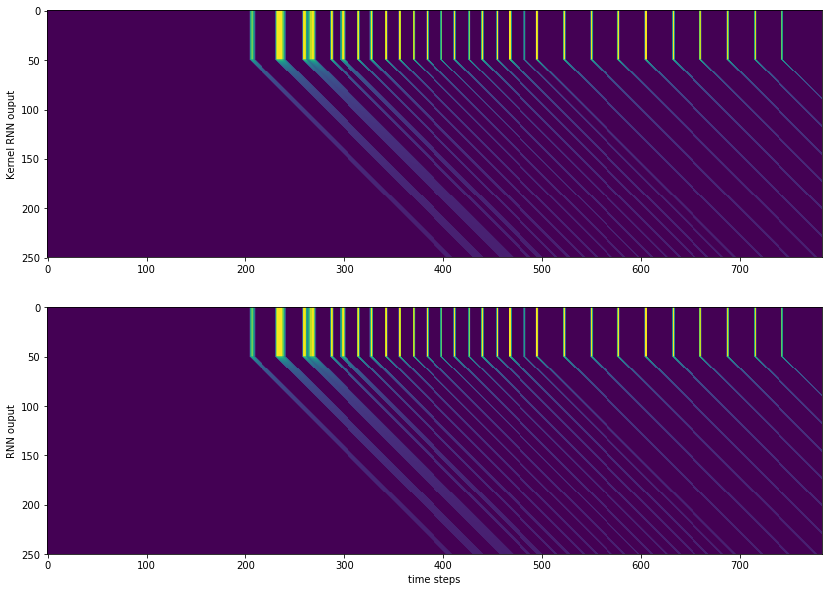

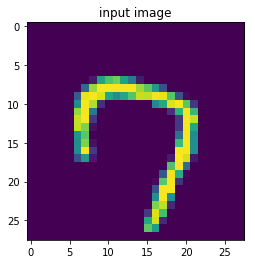

In [67]:
with tf.Session(graph=graph) as sess:
    sess.run(init)
    batch_x,batch_y=mnist.train.next_batch(batch_size)
    batch_x = batch_x.reshape((batch_size, timesteps, num_input))
    kernel_final_class, kernel_outputs=sess.run([kernel_logits, kernel_all_logits], feed_dict={X: batch_x})
    rnn_final_class, rnn_outputs=sess.run([rnn_logits, rnn_all_logits], feed_dict={X: batch_x})
    
outputs_np=np.asarray(kernel_outputs[9])
rnn_ouputs_np=np.asarray(rnn_outputs[9])
plt.figure(figsize=[15,10])
plt.subplot(211)
plt.imshow(np.vstack([np.tile(np.transpose(batch_x[9]),[50,1]),outputs_np.transpose()]))
plt.ylabel('Kernel RNN ouput')
ax=plt.subplot(212)
ax.imshow(np.vstack([np.tile(np.transpose(batch_x[9]),[50,1]),rnn_ouputs_np.transpose()]))
plt.ylabel('RNN ouput')
plt.xlabel('time steps')
plt.figure()
plt.imshow(batch_x[9].reshape(28,28))
plt.title('input image')

next step is looking at internal parameters 

In [77]:
def kernel(x, weights, biases):

    # Prepare data shape to match `rnn` function requirements
    # Current data input shape: (batch_size, timesteps, n_input)
    # Required shape: 'timesteps' tensors list of shape (batch_size, n_input)

    # Unstack to get a list of 'timesteps' tensors of shape (batch_size, n_input)
    
    # using variable scope to initialize to identity 
    #with tf.variable_scope('recurrent',initializer=tf.initializers.identity()) as scope: 
        # Define a lstm cell with tensorflow
    kernel_cell = KernelRNNCell(num_units=num_hidden,num_inputs=num_input,output_is_tuple=True,noise_std=0.0,kernel_initializer=tf.initializers.truncated_normal)
        # Get lstm cell output
    kernel_outputs, kernel_states = tf.nn.dynamic_rnn(kernel_cell, x, dtype=tf.float32)

    # Linear activation, using rnn inner loop last output
    return kernel_outputs, kernel_states

In [78]:
tf.reset_default_graph()
graph=tf.Graph()
with graph.as_default():
    # Define weights
    weights = {
        'out': tf.Variable(tf.random_normal([num_hidden, num_classes]),name='output_weight')
    }
    biases = {
        'out': tf.Variable(tf.random_normal([num_classes]),name='output_bias')
    }
    X = tf.placeholder("float", [None, 300, num_input])
    Y = tf.placeholder("float", [None, num_classes])
    outputs, states = kernel(X, weights, biases)
    init = tf.global_variables_initializer()
    variable_names=[v.name for v in tf.trainable_variables()]

In [79]:
with tf.Session(graph=graph) as sess:
    sess.run(init)
    batch_x,batch_y=mnist.train.next_batch(batch_size)
    batch_x = batch_x.reshape((batch_size, timesteps, num_input))
    batch_x = batch_x[:,0:300,:]
    network_ouput, network_state=sess.run([outputs, states], feed_dict={X: batch_x})
    

In [80]:
[v.shape for v in network_ouput]

[(128, 300, 200),
 (128, 300, 200),
 (128, 300, 200),
 (128, 300, 200),
 (128, 300, 200, 1),
 (128, 300, 200, 200),
 (128, 300, 200)]

In [81]:
network_ouput._fields

('h',
 'h_hat',
 'Theta',
 'Gamma',
 'input_trace',
 'recurrent_trace',
 'delta_sensitivity')

ValueError: cannot reshape array of size 300 into shape (28,newaxis)

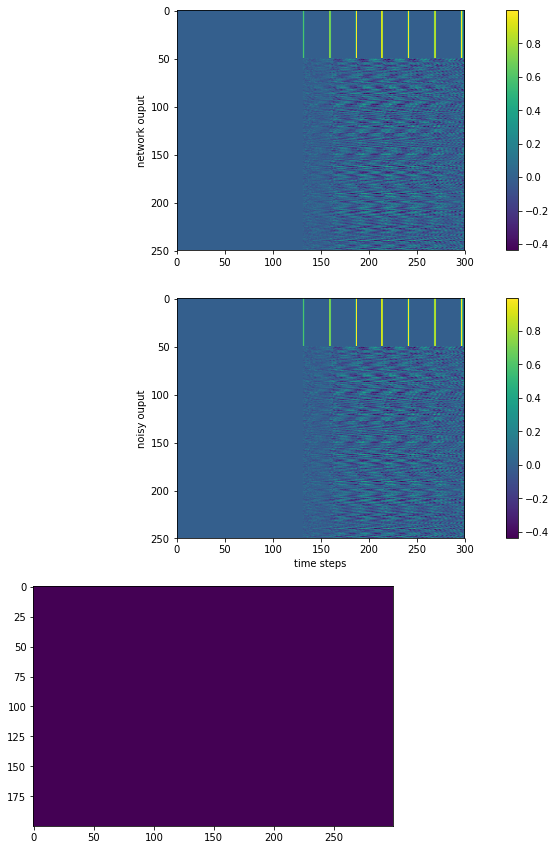

<Figure size 432x288 with 0 Axes>

In [82]:
outputs_np=np.asarray(network_ouput.h[9])
noisy_outputs_np=np.asarray(network_ouput.h_hat[9])
plt.figure(figsize=[15,15])
plt.subplot(311)
plt.imshow(np.vstack([np.tile(np.transpose(batch_x[9]),[50,1]),outputs_np.transpose()]))
plt.ylabel('network ouput')
plt.colorbar()
ax=plt.subplot(312)
ax.imshow(np.vstack([np.tile(np.transpose(batch_x[9]),[50,1]),noisy_outputs_np.transpose()]))
plt.colorbar()
plt.ylabel('noisy ouput')
plt.xlabel('time steps')
ax=plt.subplot(313)
ax.imshow(outputs_np.transpose()-noisy_outputs_np.transpose())

plt.figure()
plt.imshow(batch_x[9].reshape(28,-1))
plt.title('input image')

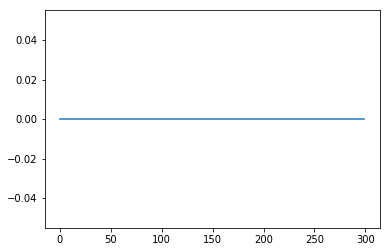

In [83]:
plt.figure()
plt.plot(np.mean(outputs_np.transpose()-noisy_outputs_np.transpose(),0))

Text(0.5, 1.0, 'Noise covariance')

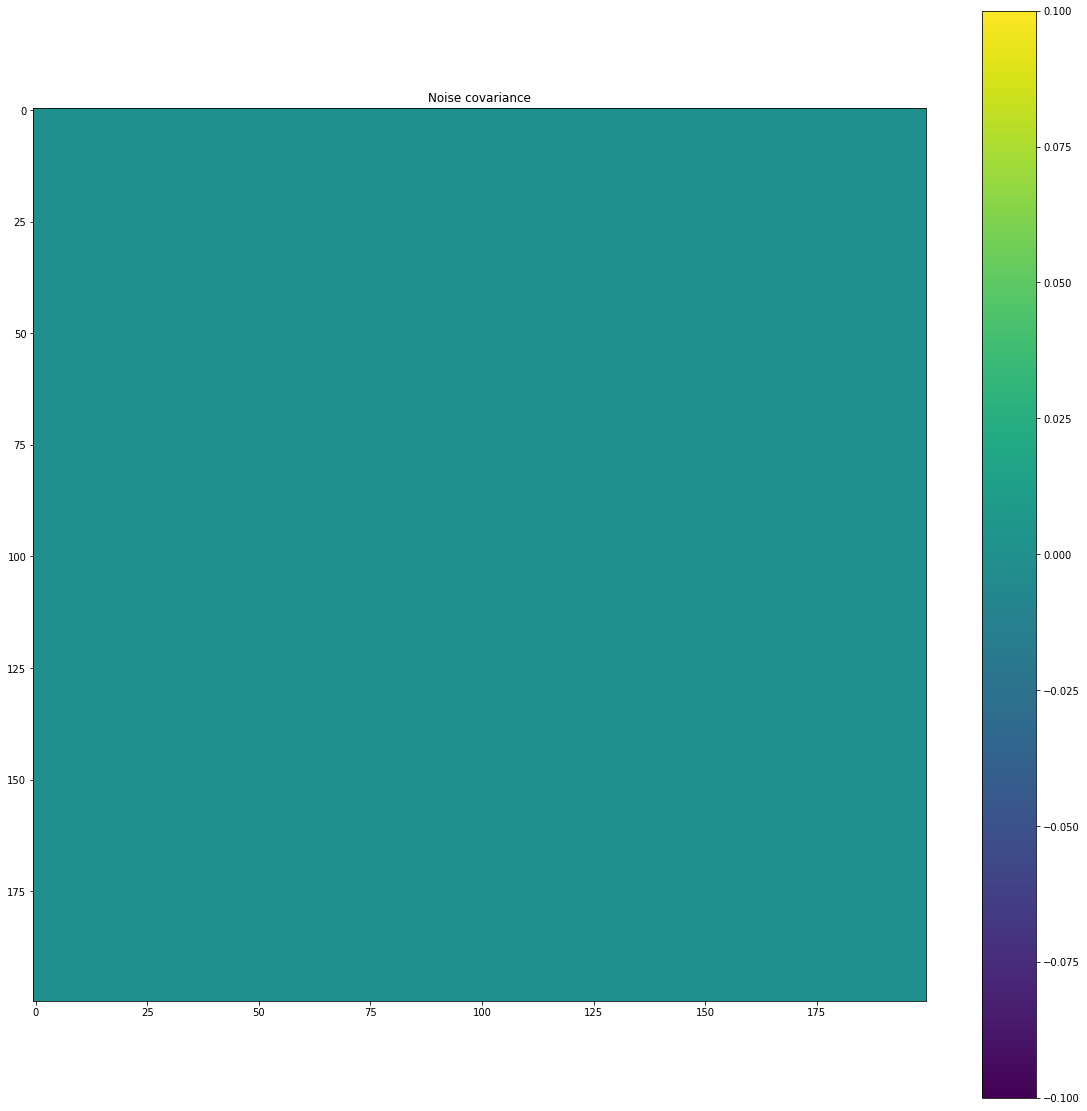

In [84]:
plt.figure(figsize=[20,20])
plt.imshow(np.cov(outputs_np.transpose()-noisy_outputs_np.transpose()))
plt.colorbar()
plt.title('Noise covariance')

In [85]:
network_ouput.Theta.shape

(128, 300, 200)

Text(0.5, 0, 'time steps')

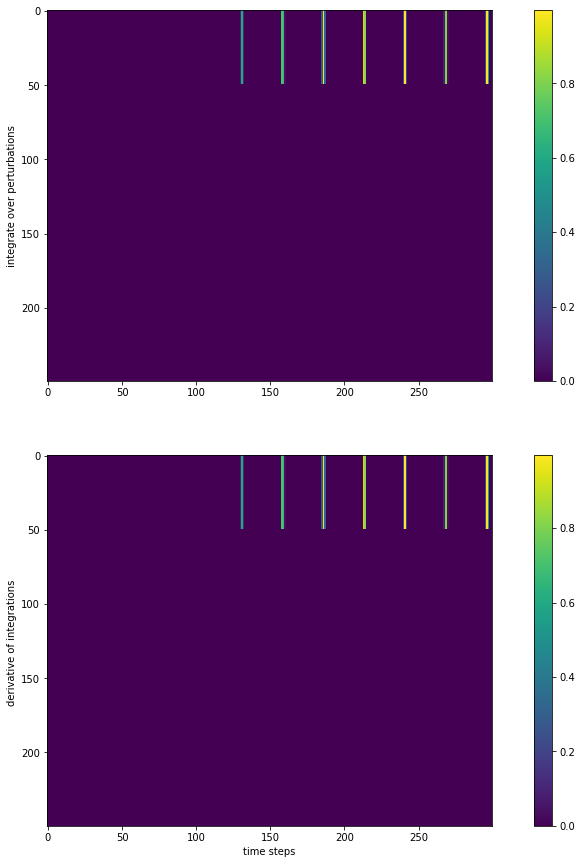

In [86]:
Theta_np=np.asarray(network_ouput.Theta[9])
Gamma_np=np.asarray(network_ouput.Gamma[9])
plt.figure(figsize=[15,15])
plt.subplot(211)
plt.imshow(np.vstack([np.tile(np.transpose(batch_x[9]),[50,1]),Theta_np.transpose()]))
plt.ylabel('integrate over perturbations')
plt.colorbar()
ax=plt.subplot(212)
ax.imshow(np.vstack([np.tile(np.transpose(batch_x[9]),[50,1]),Gamma_np.transpose()]))
plt.colorbar()
plt.ylabel('derivative of integrations ')
plt.xlabel('time steps')

